# Quantum-Inspired Feature Mapping

This notebook applies quantum-inspired feature expansion using Random Fourier Features.

## Overview
1. Load baseline graph
2. Initialize quantum feature mapper
3. Transform node features
4. Visualize feature distributions
5. Create and save quantum graph

**Estimated time:** 1-2 minutes

In [10]:
# Clear any cached src imports
import sys
if 'src' in sys.modules:
    del sys.modules['src']
for key in list(sys.modules.keys()):
    if key.startswith('src.'):
        del sys.modules[key]
print("✓ Cleared cached imports")

✓ Cleared cached imports


In [11]:
import sys
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import os

# Add project root to sys.path
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.quantum_features import LearnableQuantumFeatureMap
from src.config import QUANTUM_CONFIG, TRAINING_CONFIG, ARTIFACTS_DIR, FIGURES_DIR, ARTIFACT_FILES, FIGURE_FILES
from src.utils import get_device

device = get_device()
print("✓ Libraries imported")

Device: cpu
✓ Libraries imported


## 1. Import Libraries & Setup

In [12]:
graph_path = ARTIFACTS_DIR / ARTIFACT_FILES['baseline_graph']
data = torch.load(graph_path, weights_only=False).to(device)
print(f"Original features: {data.x.shape}")

# Check for NaN values
nan_count = torch.isnan(data.x).sum().item()
if nan_count > 0:
    print(f"⚠️  Found {nan_count} NaN values in features")
    print("   Replacing NaN with 0.0...")
    data.x = torch.nan_to_num(data.x, nan=0.0)
    print(f"✓ NaN values handled")

print(f"Original range: [{data.x.min():.4f}, {data.x.max():.4f}]")

# CRITICAL FIX: Normalize features BEFORE quantum transformation
# This ensures consistent scale and prevents large values from dominating
print("\n📊 Normalizing features (mean=0, std=1)...")

# Check if we have train_mask, otherwise use all labeled data
if hasattr(data, 'train_mask'):
    train_x = data.x[data.train_mask]
    print(f"   Using {data.train_mask.sum()} training samples for normalization")
else:
    train_x = data.x[data.labeled_mask] if hasattr(data, 'labeled_mask') else data.x
    print(f"   Using {len(train_x)} samples for normalization")

mean = train_x.mean(dim=0, keepdim=True)
std = train_x.std(dim=0, keepdim=True)
std = torch.where(std == 0, torch.ones_like(std), std)  # Avoid division by zero

data.x = (data.x - mean) / std
data.x = torch.clamp(data.x, min=-10, max=10)  # Clip extreme values
print(f"Normalized range: [{data.x.min():.4f}, {data.x.max():.4f}]")

# Initialize learnable quantum feature mapper
print("\n🔬 Initializing learnable quantum feature mapper...")
feature_mapper = LearnableQuantumFeatureMap(
    input_dim=data.num_node_features,
    expansion_factor=QUANTUM_CONFIG['expansion_factor'],
    use_fourier=QUANTUM_CONFIG['fourier_features'],
    random_seed=TRAINING_CONFIG['random_seed']
).to(device)

print(f"Mapping: {data.num_node_features} -> {feature_mapper.output_dim}")
print(f"Learnable parameters: {sum(p.numel() for p in feature_mapper.parameters()):,}")

# Apply quantum transformation
x_quantum = feature_mapper(data.x)
print(f"\nQuantum features: {x_quantum.shape}")

Original features: torch.Size([203769, 182])
⚠️  Found 16405 NaN values in features
   Replacing NaN with 0.0...
✓ NaN values handled
Original range: [-13.0934, 445268.0000]

📊 Normalizing features (mean=0, std=1)...
   Using 46564 samples for normalization
Normalized range: [-10.0000, 10.0000]

🔬 Initializing learnable quantum feature mapper...
Mapping: 182 -> 364
Learnable parameters: 34,034

Quantum features: torch.Size([203769, 364])


## 2. Load Graph & Apply Quantum Transformation

Load the baseline graph and apply quantum feature mapping to expand the feature space.


Original Features:
  Mean: -0.0677
  Std:  0.7591
  Min:  -10.0000
  Max:  10.0000

Quantum Features:
  Mean: -0.0000
  Std:  1.0000
  Min:  -1.6135
  Max:  1.5936


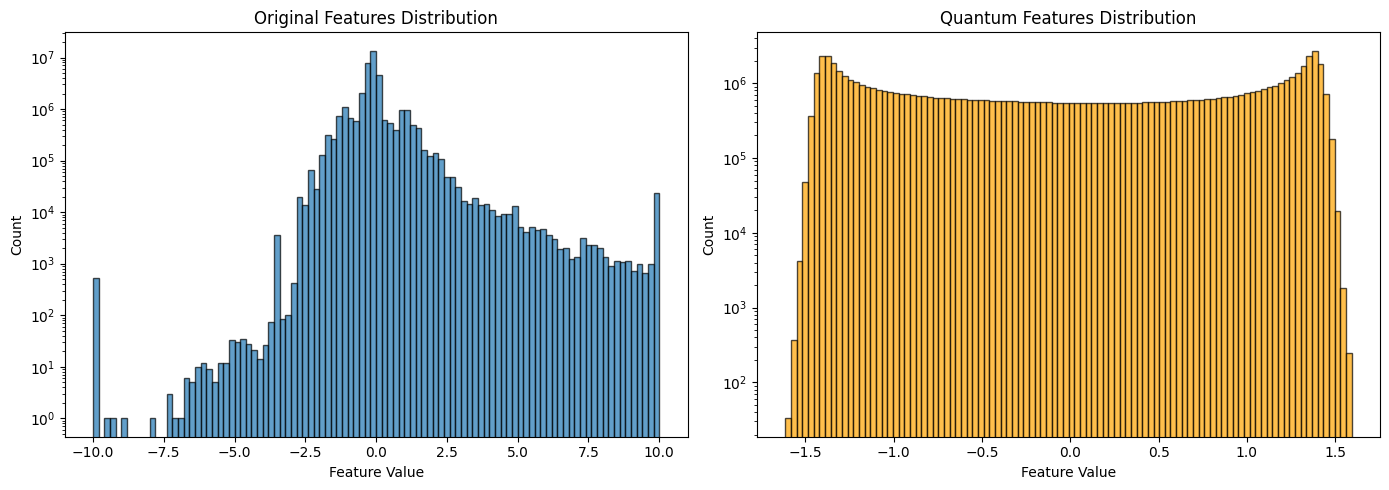


✓ Figure saved to c:\Users\tusha\Documents\UT_Dallas\ACM_SP26\Kryptos---Quantum-Blockchain-Fraud-Detection\figures\quantum_feature_distribution.png


In [7]:
import numpy as np

print("\nOriginal Features:")
print(f"  Mean: {data.x.mean().item():.4f}")
print(f"  Std:  {data.x.std().item():.4f}")
print(f"  Min:  {data.x.min().item():.4f}")
print(f"  Max:  {data.x.max().item():.4f}")

print("\nQuantum Features:")
print(f"  Mean: {x_quantum.mean().item():.4f}")
print(f"  Std:  {x_quantum.std().item():.4f}")
print(f"  Min:  {x_quantum.min().item():.4f}")
print(f"  Max:  {x_quantum.max().item():.4f}")

# Visualize feature distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Filter out NaN values for visualization
original_flat = data.x.cpu().numpy().flatten()
original_flat = original_flat[~np.isnan(original_flat)]

quantum_flat = x_quantum.detach().cpu().numpy().flatten()
quantum_flat = quantum_flat[~np.isnan(quantum_flat)]

# Original features
axes[0].hist(original_flat, bins=100, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Feature Value')
axes[0].set_ylabel('Count')
axes[0].set_title('Original Features Distribution')
axes[0].set_yscale('log')

# Quantum features
axes[1].hist(quantum_flat, bins=100, alpha=0.7, 
             color='orange', edgecolor='black')
axes[1].set_xlabel('Feature Value')
axes[1].set_ylabel('Count')
axes[1].set_title('Quantum Features Distribution')
axes[1].set_yscale('log')

plt.tight_layout()
save_path = FIGURES_DIR / FIGURE_FILES['quantum_features']
plt.savefig(save_path, dpi=150)
plt.show()
print(f"\n✓ Figure saved to {save_path}")

## 3. Compare Feature Statistics

Compare the statistical properties of original vs quantum-transformed features.

In [8]:
from torch_geometric.data import Data

# Create quantum graph with all attributes
print("\n📦 Creating quantum graph data object...")
data_quantum = Data(
    x=x_quantum,
    edge_index=data.edge_index,
    y=data.y,
    timestep=data.timestep,
    labeled_mask=data.labeled_mask,
    unlabeled_mask=data.unlabeled_mask
)

# Copy masks if they exist from previous training
if hasattr(data, 'train_mask'):
    data_quantum.train_mask = data.train_mask
    data_quantum.val_mask = data.val_mask
    data_quantum.test_mask = data.test_mask
    print("✓ Copied train/val/test masks from baseline graph")

# Store the feature mapper for use during training
data_quantum.feature_mapper = feature_mapper

print(f"\nQuantum graph: {data_quantum}")
print(f"Features: {data_quantum.x.shape[0]} nodes × {data_quantum.x.shape[1]} quantum features")


📦 Creating quantum graph data object...

Quantum graph: Data(x=[203769, 364], edge_index=[2, 672479], y=[203769], timestep=[203769], labeled_mask=[203769], unlabeled_mask=[203769], feature_mapper=LearnableQuantumFeatureMap(
  (layer_norm): LayerNorm((364,), eps=1e-05, elementwise_affine=True)
))
Features: 203769 nodes × 364 quantum features


## 4. Create Quantum Graph Data Object

Bundle quantum features with the same graph structure and masks.

In [9]:
save_path = ARTIFACTS_DIR / ARTIFACT_FILES['quantum_graph']
torch.save(data_quantum, save_path)
print(f"\nQuantum graph saved to {save_path}")
print("Proceed to 06_train_gat_quantum.ipynb")


Quantum graph saved to c:\Users\tusha\Documents\UT_Dallas\ACM_SP26\Kryptos---Quantum-Blockchain-Fraud-Detection\artifacts\elliptic_graph_quantum.pt
Proceed to 06_train_gat_quantum.ipynb


---

## ✅ Quantum Feature Mapping Complete!

Features expanded from {original} to {quantum} dimensions. Proceed to **06_train_gat_quantum.ipynb** to train with quantum features.

## 5. Save Quantum Graph